In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
from top2vec import Top2Vec
from scipy.stats import zscore
from helpers.infodynamics import InfoDynamics
from helpers.metrics import jsd, kld, softmax
from helpers.afa import adaptive_filter
from tqdm import tqdm
from helpers import visuals as vz
from collections import Counter

with open('config.json','r') as f:
    cf = json.load(f)

/home/rb/.virtualenvs/phd_venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
t2v = Top2Vec.load(cf['model_path'])
topic_words, word_scores, topic_nums = t2v.get_topics()
keys = {c:' '.join(tw[:15]) for c,tw in enumerate(topic_words)}

In [3]:
data = pd.read_csv(cf['metadata_path'],sep='\t',parse_dates=['date'])
dists = pd.read_csv(cf['doc_dist_path'],sep='\t')

data = data[(data.role != 'chair')].sort_values(['date','speech_id'])
dists = dists.loc[data.index]

dists = dists.to_numpy()
dists = np.apply_along_axis(softmax,1,dists)
timestamps = data.date.tolist()

print(len(dists))

53525


In [4]:
for wd in [5,10,25,50]:
    ntr = InfoDynamics(data = dists, time = timestamps, window = wd, group_windows = True)
    ntr.fit(meas=kld)
    ntr_ = pd.DataFrame(ntr.signals,index=timestamps)
    for c in ['member-ref','role','date','speech_id']:
        ntr_[c] = data[c].tolist()
    ntr_.to_csv(f'results/ntr-res-wd-{wd}-kld.tsv',sep='\t',index=False)
    ntrp = pd.DataFrame(ntr.npointwise,index=timestamps)
    ntrp.to_csv(f'/home/rb/Documents/Data/case-studies/novelty/ntr-n-pointwise-wd-{wd}-kld.tsv',sep='\t',index=False)

    ntrp = pd.DataFrame(ntr.tpointwise,index=timestamps)
    ntrp.to_csv(f'/home/rb/Documents/Data/case-studies/novelty/ntr-t-pointwise-wd-{wd}-kld.tsv',sep='\t',index=False)

53525it [04:55, 180.98it/s]
53525it [05:11, 171.87it/s]
53525it [04:39, 191.28it/s]
53525it [04:39, 191.54it/s]
53525it [08:39, 102.96it/s]
53525it [08:40, 102.80it/s]
53525it [08:40, 102.92it/s]
53525it [08:39, 103.05it/s]
53525it [20:26, 43.63it/s]
53525it [20:18, 43.91it/s] 
53525it [20:20, 43.85it/s]
53525it [20:18, 43.92it/s] 
53525it [39:18, 22.69it/s]
53525it [39:09, 22.79it/s] 
53525it [39:14, 22.74it/s]
53525it [39:11, 22.76it/s] 


<AxesSubplot: xlabel='date'>

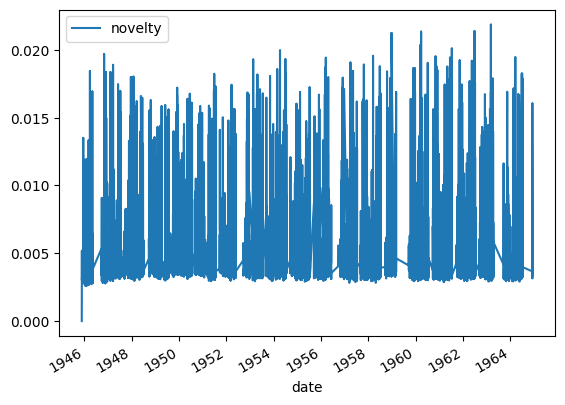

In [7]:
ntr_['n_afa'] = adaptive_filter(ntr_.novelty)

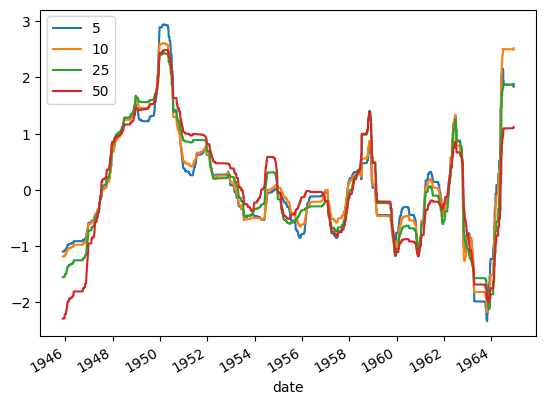

In [3]:
fig,ax = plt.subplots()

for wd in [5,10,25,50]:
    df = pd.read_csv(f'results/ntr-res-wd-{wd}-kld.tsv',sep='\t',parse_dates=['date'])
    df['n_afa'] = adaptive_filter(df.novelty)
    df['n_afa_z'] = zscore(df.n_afa)
    df.plot(x='date',y='n_afa_z',ax=ax,label=wd)
# ntr_.plot.scatter(x='date',y='novelty',ax=ax,color='lightgrey')

In [6]:
data = pd.read_csv(cf['metadata_path'],sep='\t',parse_dates=['date'])

In [45]:
docs, sims, ids = t2v.search_documents_by_keywords(['efficient','deskundig','democratie','parlement'],50)
vcs = t2v.document_vectors[ids]
typical_words = [' '.join([t2v.search_words_by_vector(v,25)][0][0]) for v in vcs]
docs = data.loc[ids]
docs['typ_words'] = typical_words

In [51]:
docs[docs.lemm_cleaned.str.contains('effici')]

,member-ref,role,date,speech_id,lemm_cleaned,typ_words
24428,nl.m.00471,mp,1953-07-09,nl.proc.sgd.d.195219530000301.2.9,mede beginnen dank betuigen mogelijkheid schep...,functioneel parlementair organisch hoofdgedach...
48964,nl.m.01021,mp,1960-02-02,nl.proc.sgd.d.195919600000228.3.3,laten beginnen politiek vriend verheugen goed ...,bondgenootschap wereldpolitiek atlantisch euro...
18310,nl.m.01304,government,1951-11-21,nl.proc.sgd.d.195119520000708.2.2,buitenlands zaak zetten rede voort beknopt bes...,atlantisch westeuropees europees westelijke in...
55094,nl.m.00467,mp,1961-02-22,nl.proc.sgd.d.196019610000214.2.48,bezwaar dergelijk verlangen verlangen onredeli...,geheim constitutioneel parlement publiek gehei...
37583,nl.m.01151,mp,1956-12-04,nl.proc.sgd.d.195619570000224.2.3,vandaag maal voorrecht begrotingsbehandeling b...,bondgenootschap alliantie wereld bondgenoot va...
30212,nl.m.01868,government,1954-12-22,nl.proc.sgd.d.195419550000320.6.4,buitenlands zaak terug spelen belangrijk rol r...,supranationaal westeuropees assemblee westeuro...
20677,na,mp,1952-02-07,nl.proc.sgd.d.195119520000734.5.2,citaat goed vergelijken planschuman verdrag ka...,confederatie supranationaal planschuman integr...
8522,nl.m.01304,government,1949-02-04,nl.proc.sgd.d.194819490000477.2.4,buitenlands zaak poging kanaal liggen klip ken...,westelijke mogendheid assemblee consultatief c...
21081,nl.m.00240,mp,1952-03-13,nl.proc.sgd.d.195119520000750.3.2,behandeling overig regering voorstellen grondw...,stilzwijgen toetsingsrecht parlement plechtig ...
10991,nl.m.01304,government,1949-11-23,nl.proc.sgd.d.194919500000582.2.2,buitenlands zaak zetten rede voort gisteren af...,buitenlandse buitenlands westelijke assemblee ...


In [50]:
docs.lemm_cleaned[44330]

'staan algemeen beschouwing beginnen opmerking politiek toestand land algemeen uitslag verkiezing provinciaal staat gemeenteraad bespreken algemeen beeld verkiezingsuitslag reactie kracht afbraak levenspeil werken volk democratisch recht aansturen verkiezing toestand ogenblik spelen groot rol plaats einde hoogconjunctuur groot ondernemer oog hierop offensief beginnen winst veilig groot kost arbeider landbouwende bevolking middenstand offensief leren kennen vorm verscherpen bestedingsbeperking werker kant afpersen belastingvermindering ondernemer industrie hiermede gaan paren aanval democratisch recht algemeen bijzonder poging vrijheid arbeidersklasse verdedigen loon arbeidsvoorwaarde verin perken kras staal gebied bouwbedrijf waarbij justitie inschakelen staking breken einde loon arbeider verlagen vonnissen uitspreken waardoor grondwettig recht arbeider middel waardeloos verschijnsel land staan zichtbaar verband algemeen tendens herhalen oud politiek dertiger jaar wereldoorlog voelen z